In [ ]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage as ndimage

In [ ]:
# Some constants 
INPUT_FOLDER = './stage1'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print(len(patients))
patients
#patients.remove('.DS_Store')

1595


['0015ceb851d7251b8f399e39779d1e7d',
 '0030a160d58723ff36d73f41b170ec21',
 '003f41c78e6acfa92430a057ac0b306e',
 '006b96310a37b36cccb2ab48d10b49a3',
 '008464bb8521d09a42985dd8add3d0d2',
 '0092c13f9e00a3717fdc940641f00015',
 '00986bebc45e12038ef0ce3e9962b51a',
 '00cba091fa4ad62cc3200a657aeb957e',
 '00edff4f51a893d80dae2d42a7f45ad1',
 '0121c2845f2b7df060945b072b2515d7',
 '013395589c01aa01f8df81d80fb0e2b8',
 '01de8323fa065a8963533c4a86f2f6c1',
 '01e349d34c06410e1da273add27be25c',
 '01f1140c8e951e2a921b61c9a7e782c2',
 '024efb7a1e67dc820eb61cbdaa090166',
 '0257df465d9e4150adef13303433ff1e',
 '026470d51482c93efc18b9803159c960',
 '0268f3a7a17412178cfb039e71799a80',
 '026be5d5e652b6a7488669d884ebe297',
 '02801e3bbcc6966cb115a962012c35df',
 '028996723faa7840bb57f57e28275e4c',
 '031b7ec4fe96a3b035a8196264a8c8c3',
 '0334c8242ce7ee1a6c1263096e4cc535',
 '03bd22ed5858039af223c04993e9eb22',
 '03fb0d0fdb187ee1160f09386b28c3f2',
 '03ff23e445787886f8b0cb192b3c154d',
 '043ed6cb6054cc13804a3dca342fa4d0',
 

In [ ]:
# Load the scans in given folder path
def load_scan(path):
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dicom.read_file((path + '/' + s),force = True) for s in ds]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [ ]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

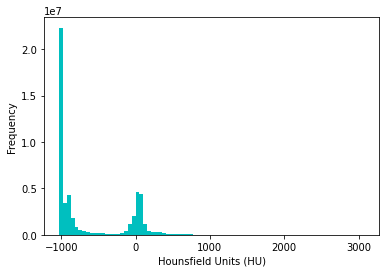

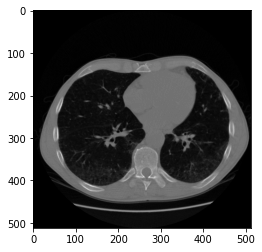

(0.0, 1.0, 0.0, 1.0)

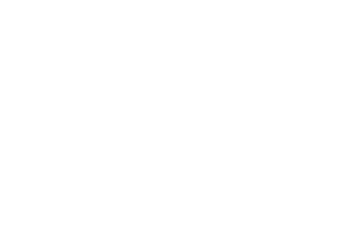

In [ ]:
first_patient = load_scan(INPUT_FOLDER +'/'+ patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[85], cmap=plt.cm.gray)
plt.show()

#plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
#plt.show()
plt.axis('off')

# Watershed algorithm

In [ ]:
test_patient_scans = load_scan(INPUT_FOLDER +'/'+ patients[1])
test_patient_images = get_pixels_hu(test_patient_scans)
test_patient_images.shape[0]

265

In [ ]:
#count=0
h=[]
for i in range(0,20):
    test_patient_scan = load_scan(INPUT_FOLDER +'/'+ patients[i])
    test_patient_image = get_pixels_hu(test_patient_scan)
    h.append(test_patient_image.shape[0])
    #s+=test_patient_image.shape[0]
print(h)

[195, 265, 233, 173, 146, 171, 123, 134, 135, 191, 217, 231, 159, 241, 175, 186, 173, 159, 106, 205]


In [ ]:
min(h[:18])

123

Internal Marker


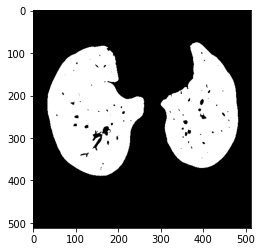

External Marker


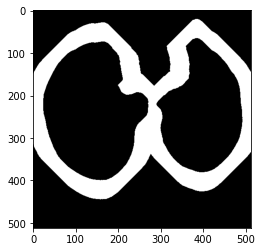

Watershed Marker


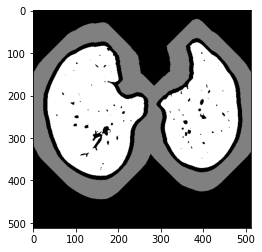

In [ ]:
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[80])
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

In [ ]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7,7)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))

    #### nodule
    lung_nodule_1 = np.bitwise_or(marker_internal, image)
    lung_nodule = np.where(lungfilter == 1, lung_nodule_1, np.zeros((512, 512)))

    
    return segmented, lung_nodule, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed


c:\users\s81\appdata\local\programs\python\python36\lib\site-packages\scipy\ndimage\morphology.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0


Lung Nodule


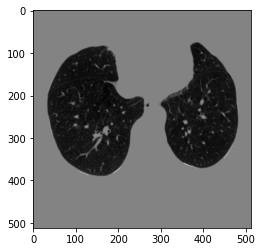

Sobel Gradient


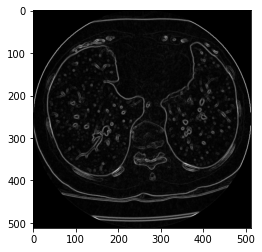

Watershed Image


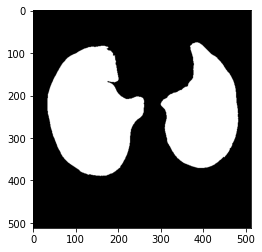

Outline after reinclusion


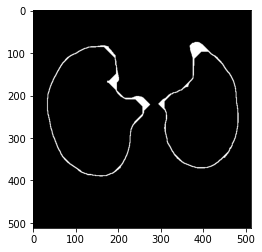

Lungfilter after closing


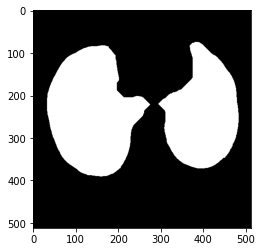

Segmented Lung


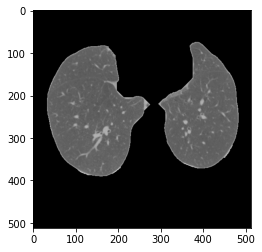

In [ ]:
#Some Testcode:
test_segmented, lung_nodule, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(test_patient_images[80])

print ("Lung Nodule")
plt.imshow(lung_nodule, cmap='gray')
plt.show()
print ("Sobel Gradient")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')
plt.show()

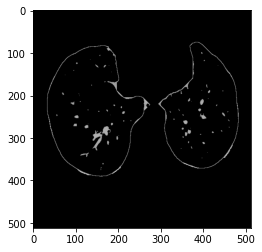

In [ ]:
test_segmented[test_segmented<-400]=-2000
plt.imshow(test_segmented,cmap='gray')
#plt.axis("off")

In [ ]:
labels_df = pd.read_csv('./stage1_labels.csv',index_col=0)
labels_d = pd.read_csv('./stage1_labels.csv')
lst=labels_d["id"].tolist()
lst

['0015ceb851d7251b8f399e39779d1e7d',
 '0030a160d58723ff36d73f41b170ec21',
 '003f41c78e6acfa92430a057ac0b306e',
 '006b96310a37b36cccb2ab48d10b49a3',
 '008464bb8521d09a42985dd8add3d0d2',
 '0092c13f9e00a3717fdc940641f00015',
 '00986bebc45e12038ef0ce3e9962b51a',
 '00cba091fa4ad62cc3200a657aeb957e',
 '00edff4f51a893d80dae2d42a7f45ad1',
 '0121c2845f2b7df060945b072b2515d7',
 '013395589c01aa01f8df81d80fb0e2b8',
 '01de8323fa065a8963533c4a86f2f6c1',
 '01e349d34c06410e1da273add27be25c',
 '01f1140c8e951e2a921b61c9a7e782c2',
 '024efb7a1e67dc820eb61cbdaa090166',
 '0257df465d9e4150adef13303433ff1e',
 '0268f3a7a17412178cfb039e71799a80',
 '026be5d5e652b6a7488669d884ebe297',
 '02801e3bbcc6966cb115a962012c35df',
 '028996723faa7840bb57f57e28275e4c',
 '0334c8242ce7ee1a6c1263096e4cc535',
 '03fb0d0fdb187ee1160f09386b28c3f2',
 '03ff23e445787886f8b0cb192b3c154d',
 '043ed6cb6054cc13804a3dca342fa4d0',
 '0482c444ac838adc5aa00d1064c976c1',
 '04a3187ec2ed4198a25033071897bffc',
 '04a52f49cdbfb8b99789b9e93f1ad319',
 

In [ ]:
labels_df

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1
...,...
fe26fd2bb25112b3c2ca93eb8e34f8ed,0
fe45462987bacc32dbc7126119999392,1
fe5c37e82b412833b8ad0abb57978377,0


In [ ]:
count=(labels_df['cancer']==1).sum()
count

362

In [ ]:
data = []
labels = []
print('*'*30)
print("data in converting.......")
print('*'*30)
j = 0
for patient in patients[:18]:
    if patient in lst:
        test_patient_scans = load_scan(INPUT_FOLDER +'/'+ patients[j])
        test_patient_images = get_pixels_hu(test_patient_scans)
        path = INPUT_FOLDER +'/'+ patient
        ds = []
        for s in os.listdir(path):
            if( s != '.DS_Store'):
                ds.append(s)
        slices = [dicom.read_file((path + '/' + s),force=True) for s in ds]
        print("patient_number_{} : {}".format(j,patients[j]))
        i = 0
        for s in slices:
            try:
              #print(str(s.PatientID))
              i += 1
              if i in range(0,50):
                continue
          #taking 20 slices from each patient
              elif i in range(50, 150):
                img = test_patient_images[i]
                seg_img = seperate_lungs(img)[0]
                new_img = np.expand_dims(seg_img,axis = -1)
                label = labels_df.at[(str(s.PatientID), 'cancer')]
                data.append(new_img)
                labels.append(label)
        
                print("converted image is : "+str(len(labels)))
              else:
                break
            except IndexError:
              continue
        j += 1
        

print("Done")

******************************
data in converting.......
******************************
patient_number_0 : 0015ceb851d7251b8f399e39779d1e7d


c:\users\s81\appdata\local\programs\python\python36\lib\site-packages\scipy\ndimage\morphology.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0


converted image is : 1
converted image is : 2
converted image is : 3
converted image is : 4
converted image is : 5
converted image is : 6
converted image is : 7
converted image is : 8
converted image is : 9
converted image is : 10
converted image is : 11
converted image is : 12
converted image is : 13
converted image is : 14
converted image is : 15
converted image is : 16
converted image is : 17
converted image is : 18
converted image is : 19
converted image is : 20
converted image is : 21
converted image is : 22
converted image is : 23
converted image is : 24
converted image is : 25
converted image is : 26
converted image is : 27
converted image is : 28
converted image is : 29
converted image is : 30
converted image is : 31
converted image is : 32
converted image is : 33
converted image is : 34
converted image is : 35
converted image is : 36
converted image is : 37
converted image is : 38
converted image is : 39
converted image is : 40
converted image is : 41
converted image is : 42
c

converted image is : 327
converted image is : 328
converted image is : 329
converted image is : 330
converted image is : 331
converted image is : 332
converted image is : 333
converted image is : 334
converted image is : 335
converted image is : 336
converted image is : 337
converted image is : 338
converted image is : 339
converted image is : 340
converted image is : 341
converted image is : 342
converted image is : 343
converted image is : 344
converted image is : 345
converted image is : 346
converted image is : 347
converted image is : 348
converted image is : 349
converted image is : 350
converted image is : 351
converted image is : 352
converted image is : 353
converted image is : 354
converted image is : 355
converted image is : 356
converted image is : 357
converted image is : 358
converted image is : 359
converted image is : 360
converted image is : 361
converted image is : 362
converted image is : 363
converted image is : 364
converted image is : 365
converted image is : 366


converted image is : 649
converted image is : 650
converted image is : 651
converted image is : 652
converted image is : 653
converted image is : 654
converted image is : 655
converted image is : 656
converted image is : 657
converted image is : 658
converted image is : 659
converted image is : 660
converted image is : 661
converted image is : 662
converted image is : 663
converted image is : 664
converted image is : 665
converted image is : 666
converted image is : 667
converted image is : 668
converted image is : 669
patient_number_7 : 00cba091fa4ad62cc3200a657aeb957e
converted image is : 670
converted image is : 671
converted image is : 672
converted image is : 673
converted image is : 674
converted image is : 675
converted image is : 676
converted image is : 677
converted image is : 678
converted image is : 679
converted image is : 680
converted image is : 681
converted image is : 682
converted image is : 683
converted image is : 684
converted image is : 685
converted image is : 68

converted image is : 969
converted image is : 970
converted image is : 971
converted image is : 972
converted image is : 973
converted image is : 974
converted image is : 975
converted image is : 976
converted image is : 977
converted image is : 978
converted image is : 979
converted image is : 980
converted image is : 981
converted image is : 982
converted image is : 983
converted image is : 984
converted image is : 985
converted image is : 986
converted image is : 987
converted image is : 988
converted image is : 989
converted image is : 990
converted image is : 991
converted image is : 992
converted image is : 993
converted image is : 994
converted image is : 995
converted image is : 996
converted image is : 997
converted image is : 998
converted image is : 999
converted image is : 1000
converted image is : 1001
converted image is : 1002
converted image is : 1003
converted image is : 1004
converted image is : 1005
converted image is : 1006
converted image is : 1007
converted image i

converted image is : 1280
converted image is : 1281
converted image is : 1282
converted image is : 1283
converted image is : 1284
converted image is : 1285
converted image is : 1286
converted image is : 1287
converted image is : 1288
converted image is : 1289
converted image is : 1290
converted image is : 1291
converted image is : 1292
converted image is : 1293
converted image is : 1294
converted image is : 1295
converted image is : 1296
converted image is : 1297
converted image is : 1298
converted image is : 1299
converted image is : 1300
converted image is : 1301
converted image is : 1302
converted image is : 1303
converted image is : 1304
converted image is : 1305
converted image is : 1306
converted image is : 1307
converted image is : 1308
converted image is : 1309
converted image is : 1310
converted image is : 1311
converted image is : 1312
converted image is : 1313
converted image is : 1314
converted image is : 1315
converted image is : 1316
converted image is : 1317
converted im

converted image is : 1589
converted image is : 1590
converted image is : 1591
converted image is : 1592
converted image is : 1593
converted image is : 1594
converted image is : 1595
converted image is : 1596
converted image is : 1597
converted image is : 1598
converted image is : 1599
converted image is : 1600
converted image is : 1601
converted image is : 1602
converted image is : 1603
converted image is : 1604
converted image is : 1605
converted image is : 1606
converted image is : 1607
converted image is : 1608
converted image is : 1609
converted image is : 1610
converted image is : 1611
converted image is : 1612
converted image is : 1613
converted image is : 1614
converted image is : 1615
converted image is : 1616
converted image is : 1617
converted image is : 1618
converted image is : 1619
converted image is : 1620
converted image is : 1621
converted image is : 1622
converted image is : 1623
converted image is : 1624
converted image is : 1625
converted image is : 1626
converted im

In [ ]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
data_new = np.array(data)
data_new.shape

(1638, 512, 512, 1)

In [ ]:
labels_new = np.array(labels)
labels_new.shape

(1638,)

In [ ]:
from skimage.transform import  resize
import numpy as np
data_n = np.zeros((len(data_new),256,256,1))
for i in range(len(data_new)):
  image = data_new[i]
  image_resize =  resize(image, (256, 256), anti_aliasing=True)
  data_n[i] = image_resize
data_n.shape

(1638, 256, 256, 1)

In [ ]:
from numpy import save
print("saving data")
save("./data_2_256_1638.npy",data_n)
print("saving labels")
save("./labels_2_1638.npy",labels_new)

saving data
saving labels


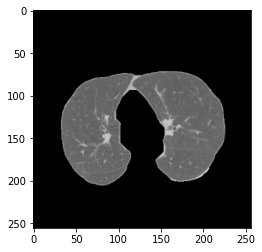

In [ ]:
plt.imshow(data[301],cmap='gray')

In [ ]:
from numpy import load
print("loading data")
data = load("./data_2_256_1638.npy")
print("loading labels")
labels = load("./labels_2_1638.npy")

loading data
loading labels


In [ ]:
data.shape

(1638, 256, 256, 1)

In [ ]:
labels.shape

(1638,)

In [ ]:
max(data1[100][125])

array([106.42916029])

In [ ]:
ne=0
po=0
n=[]
p=[]
for i in range(1638):
    if(labels[i]==0):
        ne+=1
        n.append(i)
    else:
        po+=1
        p.append(i)
        #plt.imshow(data1[i],cmap = 'gray')
print("positive : {} ; negative : {}".format(po,ne))
#print(n)
print(p)

positive : 481 ; negative : 1157
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 4

In [ ]:
import cv2

In [ ]:
labels_new=[]
c=0
for i in range(1320):
    img=cv2.imread('./images/segmented_nodules/img'+str(i)+'.png')
    #cv2.imshow("segmented nodules",img)
    lu=img[94:144,156:206]
    cv2.imwrite("./images/nodule/nodule%04i.png" %c,lu)
    c+=1
    labels_new.append(labels[i])
    ld=img[147:197,158:208]
    cv2.imwrite("./images/nodule/nodule%04i.png" %c,ld)
    c+=1
    labels_new.append(labels[i])
    ru=img[104:154,244:294]
    cv2.imwrite("./images/nodule/nodule%04i.png" %c,ru)
    c+=1
    labels_new.append(labels[i])
    rd=img[143:193,249:299]
    cv2.imwrite("./images/nodule/nodule%04i.png" %c,rd)
    c+=1
    labels_new.append(labels[i])
#cv2.imshow('cropped img',cropped_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
import glob
data=[]
for img in glob.glob('./images/segmented_nodules/*.png'):
    ii=cv2.imread(img)
    #ii = cv2.resize(ii,(224,224))
    gray_img=cv2.cvtColor(ii,cv2.COLOR_BGR2GRAY)
    y=np.expand_dims(gray_img,axis=-1)
    data.append(y)

In [ ]:
data_new = np.array(data)
data_new=data_new[:1320]
data_new.shape

(1320, 288, 432, 1)

In [ ]:
from skimage.transform import  resize
import numpy as np
data_n = np.zeros((len(data_new),224,224,1))
for i in range(len(data_new)):
  image = data_new[i]
  image_resize =  resize(image, (224, 224), anti_aliasing=True)
  data_n[i] = image_resize
data_n.shape

(1320, 224, 224, 1)

In [ ]:
labels = np.array(labels)
labels.shape

(5280,)